AMUSE tutorial on multiple code in a single bridge
====================

Hierarchical coupling strategies are fundamental parts of AMUSE.
It enables us to combined the output of a wide variety of solvers into a homogeneous solution.
In this example we will be nesting multiple bridges, to show the power of bridge.

In [1]:
import numpy
from amuse.units import (units, constants)
from amuse.lab import Particles
from amuse.units import nbody_system
from matplotlib import pyplot

In [2]:
## source https://en.wikipedia.org/wiki/TRAPPIST-1
trappist= {"b": {"m": 1.374 | units.MEarth,
                 "a": 0.01154 | units.au,
                 "e": 0.00622,
                 "i": 89.56},
           "c": {"m": 1.308 | units.MEarth,
                 "a": 0.01580 | units.au,
                 "e": 0.00654,
                 "i": 89.70},
           "d": {"m": 0.388 | units.MEarth,
                 "a": 0.02227 | units.au,
                 "e": 0.00837,
                 "i": 89.89},
           "e": {"m": 0.692 | units.MEarth,
                 "a": 0.02925 | units.au,
                 "e": 0.00510,
                 "i": 89.736},
           "f": {"m": 1.039 | units.MEarth,
                 "a": 0.03849 | units.au,
                 "e": 0.01007,
                 "i": 89.719},
           "g": {"m": 1.321 | units.MEarth,
                 "a": 0.04683 | units.au,
                 "e": 0.00208,
                 "i": 89.721},
           "h": {"m": 0.326 | units.MEarth,
                 "a": 0.06189 | units.au,
                 "e": 0.00567,
                 "i": 89.796}
           }

def trappist_system():
    from amuse.ext.orbital_elements import new_binary_from_orbital_elements
    from numpy.random import uniform
    star = Particles(1)
    setattr(star, "name", "")
    setattr(star, "type", "")
    star[0].mass = 0.898 | units.MSun
    star[0].position = (0,0,0) | units.au
    star[0].velocity = (0,0,0) | units.kms
    star[0].name = "trappist"
    star[0].type = "star"
    bodies = Particles(len(trappist))
    setattr(bodies, "name", "")
    setattr(bodies, "type", "")

    for bi, planet in zip(bodies, trappist):
        true_anomaly = uniform(0, 360)
        b = new_binary_from_orbital_elements(star.mass, 
                                             trappist[planet]['m'], 
                                             trappist[planet]["a"],
                                             trappist[planet]["e"],
                                             true_anomaly = true_anomaly,
                                             inclination = trappist[planet]["i"],
                                             G = constants.G)
        bi.name = planet
        bi.type = "planet"
        bi.mass = b[1].mass
        bi.position = b[1].position - b[0].position
        bi.velocity = b[1].velocity - b[0].velocity
    return star | bodies

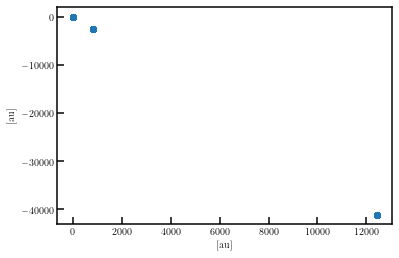

In [8]:
from amuse.community.ph4.interface import ph4
from amuse.community.hermite.interface import Hermite

from amuse.ic.plummer import new_plummer_model
import numpy.random
numpy.random.seed(1624973942)

converter=nbody_system.nbody_to_si(1 | units.MSun, 0.1|units.parsec)

t1 = trappist_system()
t2 = trappist_system()
t3 = trappist_system()
p = new_plummer_model(3, convert_nbody=converter)
t1.position += p[0].position
t1.velocity += p[0].velocity
t2.position += p[1].position
t2.velocity += p[1].velocity
t3.position += p[2].position
t3.velocity += p[2].velocity

converter=nbody_system.nbody_to_si(t1.mass.sum(), 0.1|units.au)

bodies = Particles(0)
gravity1 = ph4(converter)
t = gravity1.particles.add_particles(t1)
bodies.add_particles(t1)

gravity2 = ph4(converter)
t = gravity2.particles.add_particles(t2)
bodies.add_particles(t2)

gravity3 = Hermite(converter)
t = gravity3.particles.add_particles(t3)
bodies.add_particles(t3)

channel_from_g1 = gravity1.particles.new_channel_to(bodies)
channel_from_g2 = gravity2.particles.new_channel_to(bodies)
channel_from_g3 = gravity3.particles.new_channel_to(bodies)

from amuse.plot import scatter
from matplotlib import pyplot
scatter(bodies.x-bodies[0].x, bodies.z-bodies[0].z)
#pyplot.xlim(-0.1, 0.1)
#pyplot.ylim(-0.1, 0.1)
pyplot.show()

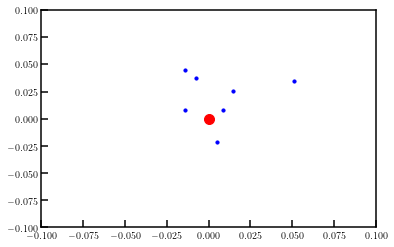

In [9]:
def plot(bodies):
    from amuse.plot import scatter
    from matplotlib import pyplot
    stars = bodies[bodies.type=='star']
    planets = bodies-stars
    pyplot.scatter((stars.x-bodies[0].x).value_in(units.au), 
                   (stars.z-bodies[0].z).value_in(units.au), c='r', s=100)
    pyplot.scatter((planets.x-bodies[0].x).value_in(units.au), 
                   (planets.z-bodies[0].z).value_in(units.au), c='b', s=10)
    pyplot.xlim(-0.1, 0.1)
    pyplot.ylim(-0.1, 0.1)
    pyplot.show()
plot(bodies)

In [ ]:
from amuse.couple import bridge
gravity = bridge.Bridge()
gravity.add_system(gravity1, (gravity2,gravity3))
gravity.add_system(gravity2, (gravity1,gravity3))
gravity.add_system(gravity3, (gravity1,gravity2))

In [ ]:
from amuse.lab import zero
Etot_init = gravity.kinetic_energy + gravity.potential_energy
Etot_prev = Etot_init

gravity.timestep = 100.0| units.yr
time = zero
dt = 200.0|units.yr
t_end = 1000.0| units.yr

while time < t_end:
    time += dt
    gravity.evolve_model(time)

    Etot_prev_se = gravity.kinetic_energy + gravity.potential_energy

    channel_from_g1.copy()
    channel_from_g2.copy()
    channel_from_g3.copy()
    plot(bodies)
    print(bodies[1].position.in_(units.au))
             
    Ekin = gravity.kinetic_energy 
    Epot = gravity.potential_energy
    Etot = Ekin + Epot
    print("T=", time.in_(units.yr), end=' ') 
    print("E= ", Etot/Etot_init, "Q= ", Ekin/Epot, end=' ')
    print("dE=", (Etot_init-Etot)/Etot, "ddE=", (Etot_prev-Etot)/Etot) 
    Etot_prev = Etot
gravity.stop()